# Generating complex densities using Diffusion models

1. moving to alphabets and number generation using diffusion models
    * We will be using JAX
    * Using U-net blocks for modelling the denoising process
    * With class conditioning
    * with batch norm to speed up training

In [1]:
!pip install --upgrade -q clu einops dm-haiku optax flax
!pip install --upgrade -q dm-tree graphviz imageio[ffmpeg]

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import einops
import math
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math
import os
from flax import jax_utils

colab = False

if not colab:
  os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
  jax.config.update('jax_platform_name', 'cpu')
Batch = Tuple[np.ndarray, np.ndarray]

2022-12-10 18:13:44.811770: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-10 18:13:45.272773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-12-10 18:13:45.273006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-12-10 18:13:45.273016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned abo

In [3]:
if colab:
  from google.colab import drive
  drive.mount('/content/gdrive')

In [4]:
train_new_model = False
cont=True
model_name = 'emnist_fixed_with_cond.jax_version.BatchNorm'

import os
import os.path as osp

if not colab:
  data_paths = osp.join(os.getcwd(), 'saved', 'saved_data')
  model_paths = osp.join(os.getcwd(), 'saved','saved_models')
  gifs_dir = osp.join(os.getcwd(), 'gifs')+"/blog/"
  dataset_path = "/home/varun/tensorflow_datasets/"
else:
  data_paths = F"/content/gdrive/MyDrive/EMNIST/data/"
  model_paths = F"/content/gdrive/MyDrive/EMNIST/model/"
  gifs_dir = F"/content/gdrive/MyDrive/EMNIST/gifs/"
  dataset_path = F"/content/gdrive/MyDrive/EMNIST/dataset/"

In [5]:
# utils 
import pickle

def load_cached(filename):
    with open(filename, 'rb') as ff:
        return pickle.load(ff)
    
def write_cached(data, filename):
    with open(filename, 'wb') as ff:
        pickle.dump(data, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# train model

# ####### i am not getting desired results with the cosine beta schedule from the hugging face repo
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = jnp.linspace(0, timesteps, steps)
    alphas_cumprod = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0.0001, 0.1)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = jnp.linspace(-6, 6, timesteps)
    return jnp.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [7]:
# Train model
timesteps = 250
# betas = linear_beta_schedule(timesteps)
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = jnp.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = jnp.sqrt(variance)

alphas_prev_ = jnp.pad(alphas_[:-1], [1, 0], "constant", constant_values=1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_) / (1 - alphas_prev_)
log_sigma_squared_q_t = jnp.log(1-alphas) + jnp.log(1-alphas_) - jnp.log(1-alphas_prev_)
sigma_squared_q_t_corrected = jnp.exp(log_sigma_squared_q_t)
key = jax.random.PRNGKey(42)

# how to add noise to the data
@jax.jit
def get_noisy(rng, batch, timestep):
    timestep = einops.repeat(timestep, 'b -> b 28 28 1')
    # we will use the reparameterization trick
    # need to generate new keys everytime
    _, noise_key = jax.random.split(rng)
    noise_at_t = jax.random.normal(noise_key, shape=batch.shape)
    added_noise_at_t = jnp.add(batch * jnp.sqrt(alphas_[timestep]), noise_at_t * sd[timestep])
    return added_noise_at_t, noise_at_t

def recover_original(batch, timestep, noise):
    true_data = jnp.subtract(batch, noise*sd[timestep])/(jnp.sqrt(alphas_[timestep]))
    return true_data

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)

## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))

# not sure why we are multiplying by 1/2 here
posterior_variance_corrected = jnp.exp(log_posterior_variance)

([<matplotlib.lines.Line2D at 0x7f43e05108e0>],
 [<matplotlib.lines.Line2D at 0x7f43d014af50>])

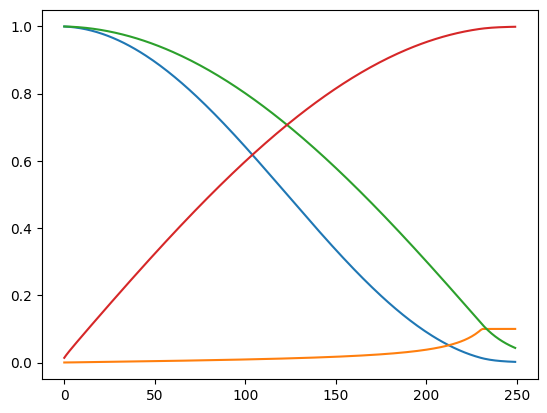

In [8]:
plt.plot(alphas_), plt.plot(posterior_variance_corrected), plt.plot(jnp.sqrt(alphas_)), plt.plot(sd)

In [9]:
#@title utils
# Various helper utility functions.

import io
import math
from IPython.display import display_png
import matplotlib as mpl
import matplotlib.cm as cm
from clu import deterministic_data

def imify(arr, vmin=None, vmax=None, cmap=None, origin=None):
  """Convert an array to an image.

  Arguments:
    arr : array-like The image data. The shape can be one of MxN (luminance),
      MxNx3 (RGB) or MxNx4 (RGBA).
    vmin : scalar, optional lower value.
    vmax : scalar, optional *vmin* and *vmax* set the color scaling for the
      image by fixing the values that map to the colormap color limits. If
      either *vmin* or *vmax* is None, that limit is determined from the *arr*
      min/max value.
    cmap : str or `~matplotlib.colors.Colormap`, optional A Colormap instance or
      registered colormap name. The colormap maps scalar data to colors. It is
      ignored for RGB(A) data.
        Defaults to :rc:`image.cmap` ('viridis').
    origin : {'upper', 'lower'}, optional Indicates whether the ``(0, 0)`` index
      of the array is in the upper
        left or lower left corner of the axes.  Defaults to :rc:`image.origin`
          ('upper').

  Returns:
    A uint8 image array.
  """
  sm = cm.ScalarMappable(cmap=cmap)
  sm.set_clim(vmin, vmax)
  if origin is None:
    origin = mpl.rcParams["image.origin"]
  if origin == "lower":
    arr = arr[::-1]
  rgba = sm.to_rgba(arr, bytes=True)
  return rgba

def rawarrview(array, **kwargs):
  """Visualize an array as if it was an image in colab notebooks.

  Arguments:
    array: an array which will be turned into an image.
    **kwargs: Additional keyword arguments passed to imify.
  """
  f = io.BytesIO()
  imarray = imify(array, **kwargs)
  plt.imsave(f, imarray, format="png")
  f.seek(0)
  dat = f.read()
  f.close()
  display_png(dat, raw=True)


def reshape_image_batch(array, cut=None, rows=None, axis=0):
  """Given an array of shape [n, x, y, ...] reshape it to create an image field.

  Arguments:
    array: The array to reshape.
    cut: Optional cut on the number of images to view. Will default to whole
      array.
    rows: Number of rows to use.  Will default to the integer less than the
      sqrt.
    axis: Axis to interpretate at the batch dimension.  By default the image
      dimensions immediately follow.

  Returns:
    reshaped_array: An array of shape [rows * x, cut / rows * y, ...]
  """
  original_shape = array.shape
  assert len(original_shape) >= 2, "array must be at least 3 Dimensional."

  if cut is None:
    cut = original_shape[axis]
  if rows is None:
    rows = int(math.sqrt(cut))

  cols = cut // rows
  cut = cols * rows

  leading = original_shape[:axis]
  x_width = original_shape[axis + 1]
  y_width = original_shape[axis + 2]
  remaining = original_shape[axis + 3:]

  array = array[:cut]
  array = array.reshape(leading + (rows, cols, x_width, y_width) + remaining)
  array = np.moveaxis(array, axis + 2, axis + 1)
  array = array.reshape(leading + (rows * x_width, cols * y_width) + remaining)
  return array

def zoom(im, k, axes=(0, 1)):
  for ax in axes:
    im = np.repeat(im, k, ax)
  return im


def imgviewer(im, zoom=3, cmap='bone_r', normalize=False, **kwargs):
  if normalize:
    im = im - im.min()
    im = im / im.max()
  return rawarrview(zoom(im, zoom), cmap=cmap, **kwargs)

# replicate = flax.jax_utils.replicate
# unreplicate = flax.jax_utils.unreplicate

In [10]:
#@title data

dataset_builder = tfds.builder('emnist', data_dir=dataset_path)
dataset_builder.download_and_prepare()

train_split = tfds.split_for_jax_process('train+train', drop_remainder=True)

def preprocess_fn(example):
  image = tf.cast(example['image'], 'float32')
  image = tf.transpose(image, (1, 0, 2,))
  image = image / 255.0
  return (image, example["label"] + 1)

batch_size = 4 * 128 if colab else 64
train_ds = deterministic_data.create_dataset(
    dataset_builder,
    split=train_split,
    rng=jax.random.PRNGKey(0),
    shuffle_buffer_size=100,
    batch_dims=[jax.local_device_count(), batch_size // jax.device_count()],
    num_epochs=None,
    preprocess_fn=lambda x: preprocess_fn(x),
    shuffle=True)

def create_input_iter(ds):
  def _prepare(xs):
    def _f(x):
      x = x._numpy()
      return x
    return jax.tree_util.tree_map(_f, xs)
  it = map(_prepare, ds)
  it = jax_utils.prefetch_to_device(it, 2)
  return it

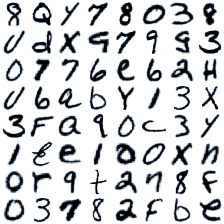

In [11]:
out = next(create_input_iter(train_ds))
rawarrview(reshape_image_batch(out[0][0].squeeze()), cmap='bone_r')

In [12]:
# adapted from Optax loss -- https://github.com/deepmind/optax/blob/master/optax/_src/loss.py
@jax.jit
def huber_loss(
    predictions,
    targets= None,
    delta= 1.):
  """Huber loss, similar to L2 loss close to zero, L1 loss away from zero.
  If gradient descent is applied to the `huber loss`, it is equivalent to
  clipping gradients of an `l2_loss` to `[-delta, delta]` in the backward pass.
  References:
    [Huber, 1964](www.projecteuclid.org/download/pdf_1/euclid.aoms/1177703732)
  Args:
    predictions: a vector of arbitrary shape `[...]`.
    targets: a vector with shape broadcastable to that of `predictions`;
      if not provided then it is assumed to be a vector of zeros.
    delta: the bounds for the huber loss transformation, defaults at 1.
  Returns:
    elementwise huber losses, with the same shape of `predictions`.
  """
  errors = (predictions - targets) if (targets is not None) else predictions
  # 0.5 * err^2                  if |err| <= d
  # 0.5 * d^2 + d * (|err| - d)  if |err| > d
  abs_errors = jnp.abs(errors)
  quadratic = jnp.minimum(abs_errors, delta)
  # Same as max(abs_x - delta, 0) but avoids potentially doubling gradient.
  linear = abs_errors - quadratic
  return jnp.mean(0.5 * quadratic ** 2 + delta * linear, axis=(1, 2, 3))

# Recommended: this can be jit'd and it should result in faster training time 
partial(jax.jit,  static_argnums=(4,))
def compute_loss(params: hk.Params, state: hk.State, batch: Batch, is_energy_method: bool=False, is_training=False) -> Tuple[jnp.ndarray, Tuple[jnp.ndarray, hk.State]]:
  """Compute the loss of the network, including L2."""
  x, label, timestep, noise = batch
  # not capturing state as it is not needed; it should be internally updated and maintaing by haiku and doesn't need gradient updates 
  pred_data, state = net.apply(params, state, x, timestep, label, is_training)
  
  def error_func():
    imp_weight = 1.0 # 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep]))
      # loss on prediction
    loss_ = jnp.mean(jnp.multiply(imp_weight, huber_loss(noise, pred_data)))
    return loss_
  
  def energy_func():
    ## Energy function interpretation
    imp_weight = 1.0 # 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (alphas[timestep]))
    # loss on prediction
    loss_ = jnp.mean(jnp.multiply(imp_weight, huber_loss(pred_data, jnp.divide(noise, -sd[timestep]))))
    return loss_
    
  loss_ = jax.lax.cond(is_energy_method, energy_func, error_func)
  return loss_, (loss_, state)

@jax.jit
def update(
    params: hk.Params,
    state: hk.State,
    opt_state: optax.OptState,
    batch: Batch,
    is_energy_method: bool=False) -> Tuple[jnp.ndarray, hk.Params, optax.OptState, hk.State]:
  """Compute gradients and update the weights"""
  grads, (loss_value, state)= jax.grad(compute_loss, has_aux=True)(params, state, batch, is_energy_method, is_training=True)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss_value, new_params, opt_state, state

@jax.jit
def ema_update(params, avg_params):
  """Incrementally update parameters via polyak averaging."""
  # Polyak averaging tracks an (exponential moving) average of the past parameters of a model, for use at test/evaluation time.
  return optax.incremental_update(params, avg_params, step_size=0.95)

@jax.jit
def unnormalize(images):
  return images*255.
  

In [13]:
# using 20% of the dataset for training, 80% for validation, although it's weird to use maximum available data for validation
# BUG: using 80% train data, since performance improvement beyond 50% wasn't seen with 20% train data
# batch_size=512
# train = load_dataset("train+test", is_training=True, batch_size=batch_size)

In [14]:
%%capture 
# % matplotlib inline 
# to discard cell output

import matplotlib.animation as animation
import imageio 
from IPython.display import Image
from matplotlib.pyplot import figure

random_index = 22
image = next(create_input_iter(train_ds))[0][0][random_index]
fig = plt.figure()
ims = []
noisy_images, _ = get_noisy(key, einops.repeat(image, 'h w c -> b h w c', b=timesteps//5), jnp.arange(0, timesteps, 5))
if colab:
  noisy_images = einops.rearrange(noisy_images, 'b h w c -> b h (w c)')
noisy_images = unnormalize(noisy_images)

for i in range(timesteps//5):
    im = plt.imshow(noisy_images[i], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=6000)
animate.save(gifs_dir+'diffusion-process.gif', writer='pillow')

def show_image(img, plt_):
  figure(figsize=(2, 2))
  if colab:
    img = einops.rearrange(img, 'h w c -> h (w c)')
  plt_.imshow(img, cmap="gray", animated=False)

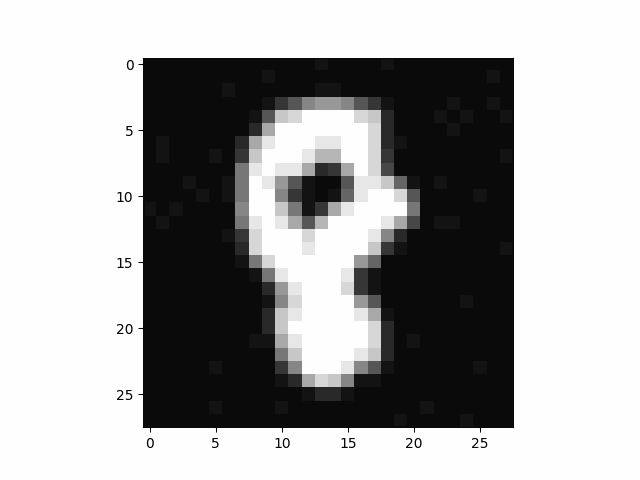

In [15]:
with open(gifs_dir + 'diffusion-process.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [54]:
nn = jnp.clip(noisy_images, 0, 1.0)
rawarrview(reshape_image_batch(nn[0:-1:3].squeeze(), rows=1), cmap='bone_r')

In [17]:
# upsample operation in the UNET
class Downsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(4, 4), stride=2, padding=[1, 1])
  
  def __call__(self, x):
    return self.conv(x)
  
# Downsample operation in the UNET
class Upsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(3, 3), padding='SAME')
  
  def __call__(self, x):
    # scaling image to twice size
    x = einops.repeat(x, 'b h w c -> b (a h) (aa w) c', a=2, aa=2)
    return self.conv(x)
      
class TimeEmbeddings(hk.Module):
  def __init__(self, dim):
    super().__init__()
    half_dim = dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    self.embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)

  def __call__(self, timesteps):
      embeddings = self.embeddings
      embeddings = jnp.multiply(timesteps[:, None], embeddings[:, None].T)
      embeddings = jnp.hstack([jnp.sin(embeddings), jnp.cos(embeddings)])
      return embeddings

class Block(hk.Module):
  # a basic resnet style convolutional block
  def __init__(self, output_channels, kernel_size, padding):
    super().__init__()
    self.proj = hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME', with_bias=False)
    # using batch norm instead of layernorm as the batch sizes are large
    # orig: self.norm = hk.LayerNorm(axis=(-3, -2, -1), create_scale=True, create_offset=True)
    self.norm = hk.BatchNorm(True, True, decay_rate=0.9)
    self.silu = jax.nn.silu
    self.conv1 = hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME', with_bias=False)
    self.norm1 = hk.BatchNorm(True, True, decay_rate=0.9)
    self.out_conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(1, 1), padding='SAME') 
    # self.time_mlp = None
    dims = output_channels
    self.time_mlp = hk.Sequential([
      jax.nn.silu,
      hk.Linear(dims*2),
    ])
    
  def __call__(self, x, timestep_embeddings=None, is_training=False):
    h = self.proj(x)
    h = self.norm(h, is_training)
    if timestep_embeddings is not None and self.time_mlp is not None:
      time_embedding = self.time_mlp(timestep_embeddings)
      time_embedding = einops.rearrange(time_embedding, 'b c -> b 1 1 c')
      shift, scale = jnp.split(time_embedding, indices_or_sections=2, axis=-1)
      h = shift + (scale+1)*h
    
    h = self.silu(self.norm1(self.conv1(self.silu(h)), is_training))
    return self.out_conv(x) + h

In [18]:
# Unet class to predict noise from a given image
class UNet(hk.Module):
  def __init__(self):
    super().__init__()
    self.init_conv = hk.Conv2D(output_channels=48, kernel_shape = (5,5), padding='SAME', with_bias=False)
    self.norm = hk.BatchNorm(True, True, decay_rate=0.9)
    self.silu = jax.nn.silu
    self.block1 = Block(output_channels=48, kernel_size=3, padding=1)
    self.downsample1 = Downsample(96)
    self.block2 = Block(output_channels=96, kernel_size=3, padding=1)
    self.downsample2 = Downsample(192)
    self.middle_block = Block(output_channels=192, kernel_size=3, padding=1)
    self.upsample1 = Upsample(96)
    self.block3 = Block(output_channels=96, kernel_size=3, padding=1)
    self.upsample2 = Upsample(48)
    self.block4 = Block(output_channels=48, kernel_size=3, padding=1)
    self.conv1 = hk.Conv2D(output_channels=48, kernel_shape = (3,3), padding='SAME', with_bias=False)
    self.norm1 = hk.BatchNorm(True, True, decay_rate=0.9)
    self.conv2 = hk.Conv2D(output_channels=1, kernel_shape = (5,5), padding='SAME')
    
    self.time_mlp = hk.Sequential([
      hk.Linear(256),
      jax.nn.gelu,
      hk.Linear(256),
    ])
    # conditional vectors encoding
    self.embedding_vectors = hk.Embed(10+26+26+1, 63)
    self.timestep_embeddings = TimeEmbeddings(96)
      
  def __call__(self, x, timesteps, cond=None, is_training=False):
    cond_embedding = None
    conditioning = None
    if timesteps is not None:
      timestep_embeddings = self.timestep_embeddings(timesteps)
      conditioning = timestep_embeddings
    if cond is not None:
      label_embeddings = self.embedding_vectors(cond)
      conditioning = jnp.concatenate([label_embeddings, conditioning], axis=1)
    if conditioning is not None:  
      cond_embedding = self.time_mlp(conditioning)
    h = self.silu(self.norm(self.init_conv(x), is_training))
    xx = jnp.copy(h)
    b1 = self.block1(h, cond_embedding, is_training)
    h = self.downsample1(b1)
    b2 = self.block2(h, cond_embedding, is_training)
    h = self.downsample2(b2)
    h = self.upsample1(self.middle_block(h, cond_embedding, is_training))
    b3 = self.block3(jnp.concatenate((h, b2), axis=3), cond_embedding, is_training)
    h = self.upsample2(b3)
    b4 = self.block4(jnp.concatenate((h, b1), axis=3), cond_embedding, is_training)
    h = self.conv2(self.silu(self.norm1(self.conv1(jnp.concatenate((xx, b4), axis=3)), is_training)))
    return h

In [19]:
def save(ckpt_dir: str, params, state, model_name) -> None:
  with open(os.path.join(ckpt_dir, model_name+"_state.pkl"), "wb") as f:
     pickle.dump(state, f)
      
  with open(os.path.join(ckpt_dir, model_name+"_params.pkl"), "wb") as f:
     pickle.dump(params, f)

def restore(ckpt_dir, model_name):
  with open(os.path.join(ckpt_dir, model_name+"_state.pkl"), "rb") as f:
    state = pickle.load(f)
 
  with open(os.path.join(ckpt_dir, model_name+"_params.pkl"), "rb") as f:
    params = pickle.load(f)
    
  return params, state

def test_model_save():
  save('saved/saved_models/', avg_params, state, 'emnist_model')
  avg_params, state = restore('saved/saved_models/', 'emnist_model')

In [20]:
import graphviz

def f(x, timesteps, label, is_training):
  unet = UNet()
  return unet(x, timesteps, label, is_training)

f_t = hk.transform_with_state(f)
net = hk.without_apply_rng(f_t)

image, label = next(create_input_iter(train_ds)) #jnp.ones([100, 28, 28, 1])
timesteps_ = jnp.arange(0, batch_size)

_, rng = jax.random.split(key)

if cont and os.path.exists(osp.join(model_paths, model_name + '_state.pkl')):
  avg_params, state = restore(model_paths, model_name)
  params = deepcopy(avg_params)
else:
  params, state = net.init(rng, image[0][0:batch_size], timesteps_, label[0][0:batch_size], is_training=True)

opt = optax.adam(1e-3)

avg_params = deepcopy(params)
opt_state = opt.init(params)



---




### Training

In [21]:
def show_predicted_image(noisy_image, params, timestep, state, label=None):
  print('time step for image: ', timestep, ' label: ', label)
  timestep = jnp.array([timestep])
  pred_noise, _ = net.apply(params, state, noisy_image, timestep, label, is_training=False)
  pred_image = noisy_image/jnp.sqrt(alphas_[timestep]) - pred_noise*sd[timestep]/jnp.sqrt(alphas_[timestep])
  _, (p1, p2) = plt.subplots(1, 2)
  show_image(unnormalize(pred_image[0]), p1)
  show_image(unnormalize(noisy_image[0]), p2)
  plt.show()
  return huber_loss(noisy_image, pred_image)
  
# show random images
# show_predicted_image(x, avg_params, 10)

In [22]:
b, l = image[0], label[0] # next(create_input_iter(train_ds))[0]

unique_key = jax.random.fold_in(key, jnp.sum(b))
_, *subkeys = jax.random.split(unique_key, timesteps)

time step for image:  249  label:  [35]


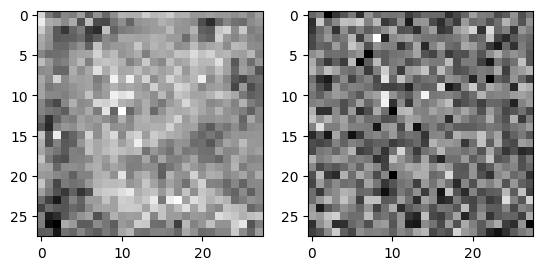

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

[0.5179791]


In [23]:
def test_loss_fn():
  loss_ = []
  huber_loss_ = []
  huber_loss_weighted = []
  imp_weight_ = []
  model_huber_loss = []
  for i in range(1, timesteps):
    tt = jnp.array([i])
    data_noisy_temp, noise_temp = get_noisy(subkeys[i-1], b, tt)
    loss_.append(jax.device_get(compute_loss(avg_params, state, [data_noisy_temp[0:1], l[0:1], tt, 
                                                          noise_temp[0:1]], is_energy_method=False, is_training=False)[0]))
    huber_loss__ = huber_loss(data_noisy_temp[0:2], b[0:2])
    huber_loss_.append(huber_loss__)
    
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[tt]) * ((betas[tt])**2 / (variance[tt] * alphas[tt]))
    # loss on prediction
    huber_loss_weighted.append(jnp.sum(jnp.multiply(imp_weight, huber_loss__)))
    imp_weight_.append(imp_weight)
    
    pp, _ = net.apply(avg_params, state, data_noisy_temp[0:1], tt, l[0:1], is_training=False)
    reconstructed = recover_original(data_noisy_temp[0:1], tt, pp)
    model_huber_loss.append(huber_loss(reconstructed[0:1], data_noisy_temp[0:1]))
    
  print(show_predicted_image(data_noisy_temp[0:1], avg_params, i, state, l[0:1]))
  return loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss
  
loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss = test_loss_fn()

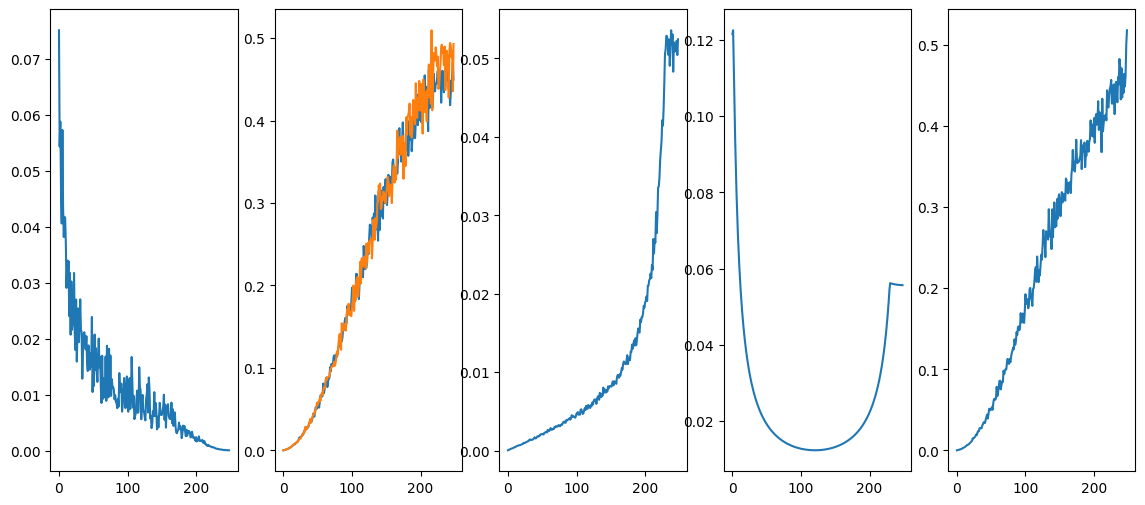

In [24]:
_, (plt1, plt2, plt3, plt4, plt5) = plt.subplots(1,5, figsize=(14, 6))

plt1.plot(loss_)
plt2.plot(huber_loss_)
plt3.plot(huber_loss_weighted)
plt4.plot(imp_weight_)
plt5.plot(model_huber_loss)

In [25]:
from copy import deepcopy
import pickle
import sys

batches_iter = 10000
one_timestep = jnp.mod(jnp.arange(1, batch_size+1), timesteps)
train = create_input_iter(train_ds) 
data_in_batch_, label_ = next(train)
data_in_batch_ = data_in_batch_[0]
label_ = label_[0]
data_noisy_temp_, noise_temp_ = get_noisy(key, data_in_batch_, one_timestep)

def train_model(opt_state, params, avg_params, state, model_name, train_new_model=False, energy_method=False):
    best_loss = sys.float_info.max # initialization   

    if train_new_model or not os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        # generating sub keys for timesteps
        unique_key = jax.random.fold_in(key, batch_size)
        
        # same subkey being used for noise sampling, as it doesn't matter :)
        _, *timestep_subkeys = jax.random.split(unique_key, batches_iter+1)
        
        losses = []
        for iteration in range(0, batches_iter):
            data_in_batch, label = next(train)
            data_in_batch = data_in_batch[0]
            label = label[0]
            idx = (jax.random.uniform(key=timestep_subkeys[iteration], shape=(batch_size, 1)) * (timesteps-1)).astype(int)
            idx = einops.rearrange(idx, 'a b -> (a b)')
            timestep = idx + 1
            data_noisy, noise = get_noisy(timestep_subkeys[iteration], data_in_batch, timestep)
            # todo: call gradient update function here
            loss_value, params, opt_state, state = update(params, state, opt_state, [data_noisy, label, timestep, noise], energy_method)
            avg_params = ema_update(params, avg_params)
            
            if iteration % 10 == 0:
              print("batch loss value: ", loss_value)
            
            if iteration % 20 == 0:                
                ## evaluating noise on a fixed timestep to calculate best model
                loss_temp, _ = jax.device_get(compute_loss(avg_params, state, [data_noisy_temp_, label_, one_timestep, noise_temp_], energy_method, is_training=False))
                losses.append(loss_temp)
            
                if loss_temp < best_loss:
                    best_loss = loss_temp
                    print(f"saving iteration: {iteration} loss: {best_loss:>7f}")
                    save(model_paths, avg_params, state, model_name)
                    write_cached([data_noisy, data_in_batch, timestep, losses], osp.join(data_paths, model_name + '_state.pt'))
            
                if iteration % 100 == 0:
                    print(f"iteration: {iteration} loss: {loss_temp:>7f}")
                    # sample a random number
                    r_ = (jax.random.uniform(timestep_subkeys[iteration])*batch_size).astype(int)
                    show_predicted_image(data_noisy_temp_[r_: r_+1], avg_params, one_timestep[r_], state, label_[r_: r_+1])

    if os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        avg_params, state = restore(model_paths, model_name)
        params = deepcopy(avg_params)
        data_noisy, data_in_batch, timestep, losses = load_cached(osp.join(data_paths, model_name + '_state.pt')) 
    return data_noisy, data_in_batch, timestep, losses, avg_params, state

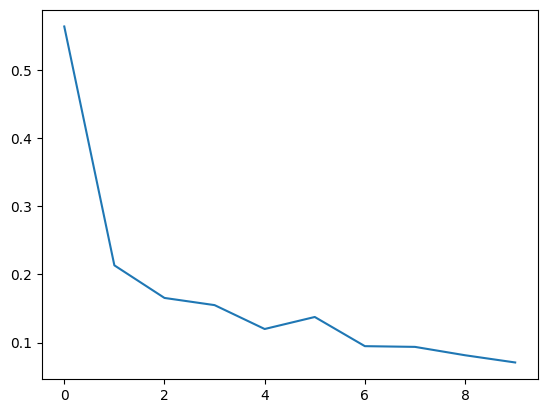

In [26]:
data_noisy, data_in_batch, timestep, losses, avg_params, state = train_model(opt_state, params, avg_params, state, model_name, train_new_model = train_new_model, energy_method=False)
plt.plot(losses)

In [27]:
def param_count(pytree):
  return sum(x.size for x in jax.tree_util.tree_leaves(pytree))

param_count(avg_params)

2233714

## Full generation model

In [28]:
mean_coeff_1 = jnp.sqrt(alphas)*(1 - alphas_prev_) / variance
mean_coeff_2 = jnp.sqrt(alphas_prev_) * betas / variance

In [29]:
import random

def generate_data(avg_params, state, label, energy_method=False, clipped_version=False):
    batch_size_generation = len(label)
    unique_key = jax.random.fold_in(key, random.randint(1, 100))
    _, subkey = jax.random.split(unique_key)
    _, *subkeys = jax.random.split(unique_key, timesteps+1)
    
    # need to generate new keys everytime
    data_noisy = jax.random.normal(subkey, shape=(batch_size_generation, 28, 28, 1))
      
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy

    for t in range(1, timesteps+1):
        timestep = timesteps-t
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data, _ = net.apply(avg_params, state, data_in_batch, t_repeated, label, is_training=False)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas[timestep])) - jnp.log(sd[timestep]))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(alphas[timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas[timestep])/jnp.sqrt(alphas[timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 0:
                x_reconstructed = jnp.clip(x_reconstructed, 0., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1[timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2[timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)

        posterior_data = posterior_variance_corrected[timestep]
        data_noisy = jax.random.normal(subkeys[t-1], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch

In [30]:
batch_size_generation = 64
datas, data_in_batch = generate_data(avg_params, state, label=jnp.mod(jnp.arange(0, batch_size_generation), 63), energy_method=False, clipped_version=True)

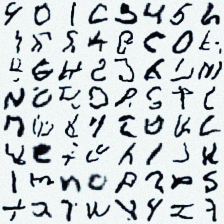

In [31]:
rawarrview(reshape_image_batch(data_in_batch.squeeze()), cmap='bone_r')

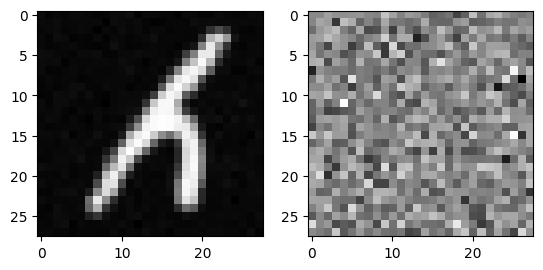

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

In [32]:
_, (plt1, plt2) = plt.subplots(1, 2)
tt = random.randint(0, batch_size_generation-1)
show_image(unnormalize(data_in_batch[tt]), plt1)
show_image(unnormalize(datas[0][tt]), plt2)
# show_image((data_orig[0]), plt3)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [33]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for i in range(0, timesteps, 10):
    im = plt.imshow(datas[i][tt], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_full_with_cond.gif', writer='pillow')

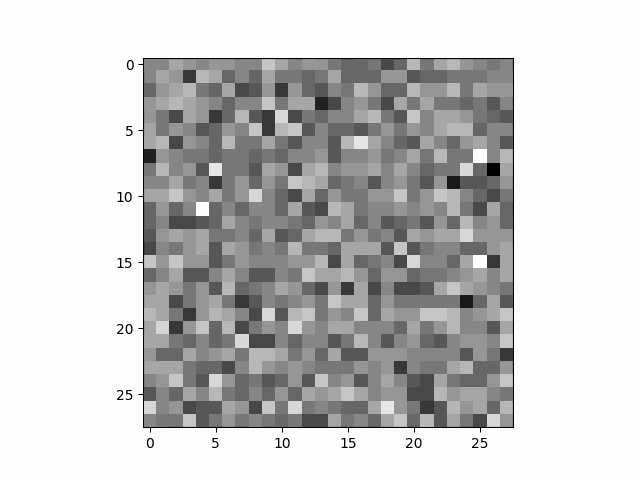

In [34]:
with open(gifs_dir + 'diffusion_generation_full_with_cond.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

## strided sampling

In [35]:
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))
posterior_variance_corrected = jnp.exp(log_posterior_variance)

strided_schedule = jnp.array(list(range(1, timesteps, 5)) + [timesteps])

alphas_strided_ = alphas_[strided_schedule]
alphas_prev_strided_ = jnp.pad(alphas_strided_[:-1], [1, 0], "constant", constant_values=1.0)

betas_strided = 1 - (alphas_strided_/alphas_prev_strided_)
posterior_variance_new_schedule = betas_strided * (1 - alphas_prev_strided_)/ (1-alphas_strided_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance_new_schedule[1], posterior_variance_new_schedule[1:]]))
posterior_variance_new_schedule_corrected = jnp.exp(log_posterior_variance)

In [36]:
mean_coeff_1_strided = jnp.sqrt(1-betas_strided)*(1 - alphas_prev_strided_) / (1 - alphas_strided_)
mean_coeff_2_strided = jnp.sqrt(alphas_prev_strided_) * betas_strided / (1 - alphas_strided_)

In [37]:
import random

def generate_data_strided(avg_params, state, label, energy_method=False, clipped_version=False):
    batch_size_generation = len(label)
    unique_key = jax.random.fold_in(key, random.randint(1, 100))
    _, subkey = jax.random.split(unique_key)
    _, *subkeys = jax.random.split(unique_key, len(strided_schedule)+1)
    
    data_noisy = jax.random.normal(subkey, shape=(batch_size_generation, 28, 28, 1))
          
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy                               
    for t in range(1, len(strided_schedule)+1):
        stride_timestep = len(strided_schedule)-t
        timestep = strided_schedule[stride_timestep]
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data, _ = net.apply(avg_params, state, data_in_batch, t_repeated, label, is_training=False)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas_strided[stride_timestep])) - jnp.log(jnp.sqrt(1- alphas_strided_[stride_timestep])))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(1-betas_strided[stride_timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas_strided[stride_timestep])/jnp.sqrt(1-betas_strided[stride_timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 0:
                x_reconstructed = jnp.clip(x_reconstructed, 0., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1_strided[stride_timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2_strided[stride_timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)



        posterior_data = posterior_variance_new_schedule_corrected[stride_timestep]
        data_noisy = jax.random.normal(subkeys[t-1], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch

In [38]:
batch_size_generation = 64
datas, data_in_batch = generate_data_strided(avg_params, state, label= jnp.mod(jnp.arange(0, batch_size_generation), 63), energy_method=False, clipped_version=True)

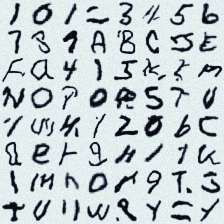

In [39]:
rawarrview(reshape_image_batch(data_in_batch.squeeze()), cmap='bone_r')

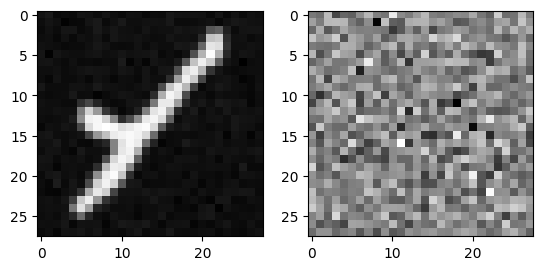

<Figure size 200x200 with 0 Axes>

<Figure size 200x200 with 0 Axes>

In [40]:
_, (plt1, plt2) = plt.subplots(1, 2)

tt = random.randint(0, batch_size_generation-1)
show_image(unnormalize(data_in_batch[tt]), plt1)
show_image(unnormalize(datas[0][tt]), plt2)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [41]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for i in range(0, len(strided_schedule)):
    im = plt.imshow(datas[i][tt], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_strided_with_cond.gif', writer='pillow')

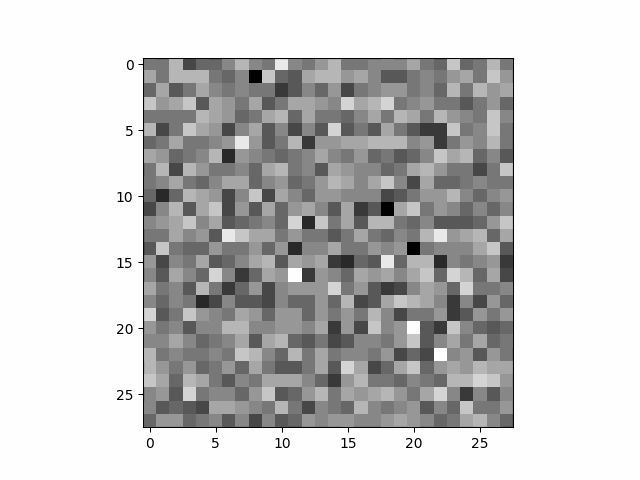

In [42]:
with open(gifs_dir + 'diffusion_generation_strided_with_cond.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [43]:
import string

x = list(range(1, 63))
y = [str(i) for i in (list(range(0, 10)))] + list(string.ascii_uppercase + string.ascii_lowercase)

dict_ = {}
for i in x:
  dict_[y[i-1]] = i
  
def get_label(ans):
  return jnp.array([dict_[str.upper(char)] for char in ans])

answer = []
answer.append(get_label("varun"))
answer.append(get_label("tulsian"))
answer.append(get_label("2001"))
answer.append(get_label("gmail"))
answer.append(get_label("com"))

In [44]:
data_in_batch = None

for l in answer:
  if data_in_batch is None:
    _, data_in_batch = generate_data(avg_params, state, label= l, energy_method=False, clipped_version=True)
  else:
    _, temp = generate_data(avg_params, state, label= l, energy_method=False, clipped_version=True)
    data_in_batch = jnp.concatenate((data_in_batch, temp), axis=0)

rawarrview(reshape_image_batch(data_in_batch.squeeze(), rows=1), cmap='bone_r')

In [45]:
_, d = generate_data(avg_params, state, label= answer[0], energy_method=False, clipped_version=True)
rawarrview(reshape_image_batch(d.squeeze(), rows=1), cmap='bone_r')

In [46]:
_, d = generate_data(avg_params, state, label= answer[1], energy_method=False, clipped_version=True)
rawarrview(reshape_image_batch(d.squeeze(), rows=1), cmap='bone_r')

In [47]:
data_in_batch = None

for l in answer:
  if data_in_batch is None:
    _, data_in_batch = generate_data_strided(avg_params, state, label= l, energy_method=False, clipped_version=True)
  else:
    _, temp = generate_data_strided(avg_params, state, label= l, energy_method=False, clipped_version=True)
    data_in_batch = jnp.concatenate((data_in_batch, temp), axis=0)

rawarrview(reshape_image_batch(data_in_batch.squeeze(), rows=1), cmap='bone_r')

In [48]:
datas, d = generate_data_strided(avg_params, state, label= answer[0], energy_method=False, clipped_version=True)
datas_ = jnp.clip(jnp.array(datas[0:-1:2]), 0., 1.)
d_ = einops.rearrange(datas_, 'a b c d e -> (b a) c d e') 

rawarrview(reshape_image_batch(datas[-1].squeeze(), rows=1), cmap='bone_r')

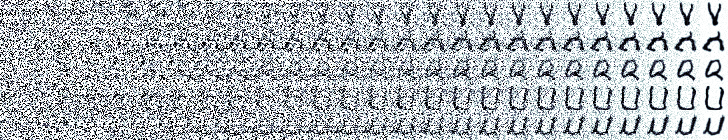

In [49]:
rawarrview(reshape_image_batch(d_.squeeze(), rows=5), cmap='bone_r')

In [50]:
datas, d = generate_data_strided(avg_params, state, label= answer[1], energy_method=False, clipped_version=True)
datas_ = jnp.clip(jnp.array(datas[0:-1:2]), 0., 1.)
d_ = einops.rearrange(datas_, 'a b c d e -> (b a) c d e') 
rawarrview(reshape_image_batch(datas[-1].squeeze(), rows=1), cmap='bone_r')

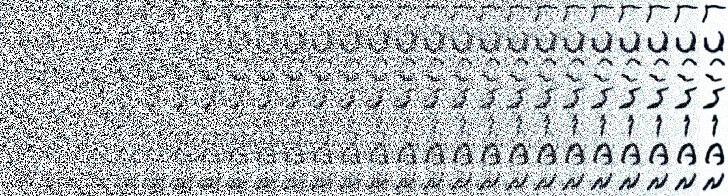

In [51]:
rawarrview(reshape_image_batch(d_.squeeze(), rows=7), cmap='bone_r')

([<matplotlib.lines.Line2D at 0x7f426fe3ca00>],
 [<matplotlib.lines.Line2D at 0x7f434c3ec310>])

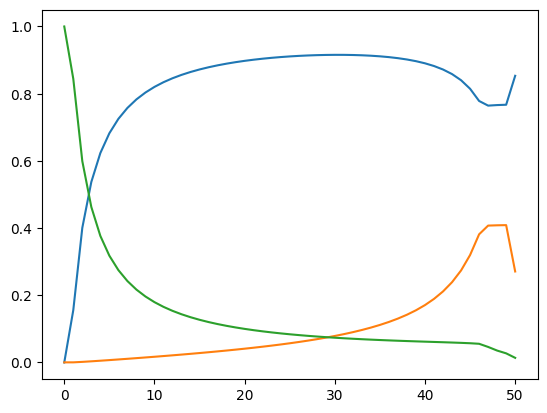

In [52]:
plt.plot(mean_coeff_1_strided), plt.plot(posterior_variance_new_schedule_corrected), plt.plot(mean_coeff_2_strided)

([<matplotlib.lines.Line2D at 0x7f43e0555030>],
 [<matplotlib.lines.Line2D at 0x7f434c390c70>])

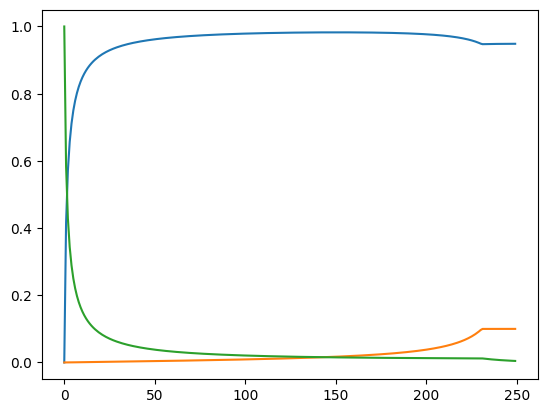

In [53]:
plt.plot(mean_coeff_1), plt.plot(posterior_variance_corrected), plt.plot(mean_coeff_2)

In [68]:
for i in range(1, 10):
  datas, d = generate_data(avg_params, state, label=get_label("Z"), energy_method=False, clipped_version=True)
  datas_ = jnp.clip(jnp.array(datas[0:-1:5]), 0., 1.)
  d_ = einops.rearrange(datas_, 'a b c d e -> (b a) c d e') 
  rawarrview(reshape_image_batch(d_.squeeze(), rows=1), cmap='bone_r')
# rawarrview(reshape_image_batch(datas[-1].squeeze(), rows=1), cmap='bone_r')

In [72]:
rawarrview(reshape_image_batch(d_.squeeze(), rows=1), cmap='bone_r')

In [69]:
nn = jnp.clip(noisy_images, 0, 1.0)
rawarrview(reshape_image_batch(nn[0:-1:3].squeeze(), rows=1), cmap='bone_r')